Goal of the Project: Although Machine Learning typically falls into the same domain as Computer Science, the tools and skills vary greatly from other jobs in the field such as Cyber Security or Software Developement. The goal figure out the technicial skills are required for jobs in Machine Learning for todays market. 

Import all Necesary Libraries 

In [4]:
# Web Scraping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from urllib.parse import quote_plus

# Time Recording
import time
import random

# Data Analysis
import numpy as np
import pandas as pd

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
import spacy
from fuzzywuzzy import fuzz
from nltk.util import ngrams
from collections import defaultdict

# Data Visualization (Plotting)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewhalvorsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewhalvorsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewhalvorsen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import the Dataset and read the first 5 rows

In [3]:
from pathlib import Path
import pandas as pd

data_path = Path("/Users/matthewhalvorsen/Desktop/Grad School /Fall 2025/NLP Project/ai_job_dataset.csv")

AI_jobs = pd.read_csv(data_path, encoding="utf-8", low_memory=False)
print("Loaded dataset shape:", AI_jobs.shape)
AI_jobs.head()

Loaded dataset shape: (15000, 19)


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


Sort by degree and keep salary column to find average salary by education

In [4]:
# validate columns
if 'education_required' not in AI_jobs.columns or 'salary_usd' not in AI_jobs.columns:
    raise KeyError("DataFrame must contain 'education_required' and 'salary_usd' columns")

# clean salary_usd to numeric (remove $/commas), keep NaN for non-numeric
AI_jobs['salary_usd'] = pd.to_numeric(AI_jobs['salary_usd'].astype(str).str.replace(r'[\$,]', '', regex=True), errors='coerce')

# replace missing education with a sentinel if you want them grouped
edu_series = AI_jobs['education_required'].fillna('MISSING')

# build dictionary of DataFrames keyed by education level, each containing salary_usd
groups = {edu: AI_jobs.loc[edu_series == edu, ['salary_usd']].reset_index(drop=True)
          for edu in edu_series.unique()}

# quick summary (count and mean salary)
summary = pd.DataFrame({
    'count': {k: v.shape[0] for k, v in groups.items()},
    'mean_salary_usd': {k: v['salary_usd'].mean() for k, v in groups.items()}
}).sort_values('count', ascending=False)

print(summary)

           count  mean_salary_usd
Bachelor    3789    115861.629190
Associate   3785    114605.708058
Master      3748    117171.815902
PhD         3678    113728.165579


Make new dataset with the required skills information 

In [10]:
# create job_type DataFrame with selected columns (handle slight column-name variants)
required_cols = ['job_title', 'experience_level', 'years_experience', 'required_skills']
missing = [c for c in required_cols if c not in AI_jobs.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

job_type = AI_jobs[required_cols].copy()
# drop rows missing job_title and experience_level info
job_type = job_type.dropna(subset=['job_title', 'experience_level']).reset_index(drop=True)

job_type.head()

,job_title,experience_level,years_experience,required_skills
0,AI Research Scientist,SE,9,"Tableau, PyTorch, Kubernetes, Linux, NLP"
1,AI Software Engineer,EN,1,"Deep Learning, AWS, Mathematics, Python, Docker"
2,AI Specialist,MI,2,"Kubernetes, Deep Learning, Java, Hadoop, NLP"
3,NLP Engineer,SE,7,"Scala, SQL, Linux, Python"
4,AI Consultant,EN,0,"MLOps, Java, Tableau, Python"


Look at the average amount of years for each experience level

In [11]:
import re
def _parse_years(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if 'less' in s and '1' in s:
        return 0.5
    # extract numbers like 3, 3.5, 10
    nums = re.findall(r'(\d+(?:\.\d+)?)', s)
    if not nums:
        return np.nan
    nums = [float(n) for n in nums]
    # ranges "3-5" or "3 to 5"
    if '-' in s or ' to ' in s:
        return float(np.mean(nums))
    # "3+ years" -> use the base number
    if '+' in s:
        return nums[0]
    # multiple numbers (fallback): average
    if len(nums) > 1:
        return float(np.mean(nums))
    return nums[0]

# prefer job_type if present, otherwise use AI_jobs
df_src = job_type if 'job_type' in globals() else AI_jobs

# create numeric years column
df_src['years_num'] = df_src['years_experience'].apply(_parse_years)

# group and summarize
exp_summary = df_src.groupby('experience_level')['years_num'].agg(['count', 'mean', 'median', 'std']).sort_values('count', ascending=False)
print(exp_summary)

# save results for later use/plotting
exp_summary.to_csv('experience_years_summary.csv')

                  count       mean  median       std
experience_level                                    
MI                 3781   3.014811     3.0  0.818627
EX                 3760  14.480585    15.0  2.862114
SE                 3741   6.983160     7.0  1.413073
EN                 3718   0.491662     0.0  0.499998


Now split the data by experience level and the required skills

In [14]:
# select and drop rows missing skills or experience
skills_df = job_type[['experience_level', 'required_skills']].dropna(subset=['required_skills', 'experience_level']).copy()
skills_df.head()

,experience_level,required_skills
0,SE,"Tableau, PyTorch, Kubernetes, Linux, NLP"
1,EN,"Deep Learning, AWS, Mathematics, Python, Docker"
2,MI,"Kubernetes, Deep Learning, Java, Hadoop, NLP"
3,SE,"Scala, SQL, Linux, Python"
4,EN,"MLOps, Java, Tableau, Python"


Split the data in the skills column by removing the commas and then normalize the data (give all same case)

In [15]:
# splitter / normalizer
def split_skills(s):
    parts = re.split(r'[,\n;/\|]+', str(s))        # split on common delimiters
    parts = [p.strip().lower() for p in parts if p.strip()]
    return parts

skills_df['skill_list'] = skills_df['required_skills'].apply(split_skills)

"Explode the data" by giving all the skills there own rows and check/remove any empty rows

In [16]:
exploded = skills_df.explode('skill_list').rename(columns={'skill_list': 'skill'})
exploded = exploded[exploded['skill'] != '']

Count the number of top skills per level

In [17]:
counts = (exploded.groupby(['experience_level', 'skill'])
                  .size()
                  .reset_index(name='count')
                  .sort_values(['experience_level', 'count'], ascending=[True, False]))

Create Top N skills, for this case we will use 10

In [18]:
# top N per experience level
TOP_N = 5
top_per_level = counts.groupby('experience_level').head(TOP_N).reset_index(drop=True)

In [19]:
# display concise results
for lvl, grp in top_per_level.groupby('experience_level'):
    print(f"--- {lvl} (top {TOP_N}) ---")
    print(grp[['skill','count']].to_string(index=False))
    print()

# save for later plotting/analysis
top_per_level.to_csv('top_skills_by_experience.csv', index=False)

--- EN (top 5) ---
     skill  count
    python   1151
       sql    850
kubernetes    743
tensorflow    730
   pytorch    703

--- EX (top 5) ---
     skill  count
    python   1092
       sql    819
kubernetes    749
tensorflow    748
     scala    715

--- MI (top 5) ---
     skill  count
    python   1121
       sql    858
tensorflow    761
kubernetes    751
     linux    695

--- SE (top 5) ---
     skill  count
    python   1086
       sql    880
tensorflow    783
kubernetes    766
     scala    697



Visualize the top skills required

/var/folders/q4/d0q9cnhd6vb5hhrh7chjjk5h0000gn/T/ipykernel_3902/2365662536.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='skill', data=grp, ax=ax, palette='viridis')
/var/folders/q4/d0q9cnhd6vb5hhrh7chjjk5h0000gn/T/ipykernel_3902/2365662536.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='skill', data=grp, ax=ax, palette='viridis')
/var/folders/q4/d0q9cnhd6vb5hhrh7chjjk5h0000gn/T/ipykernel_3902/2365662536.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='skill', data=grp, ax=ax, palette=

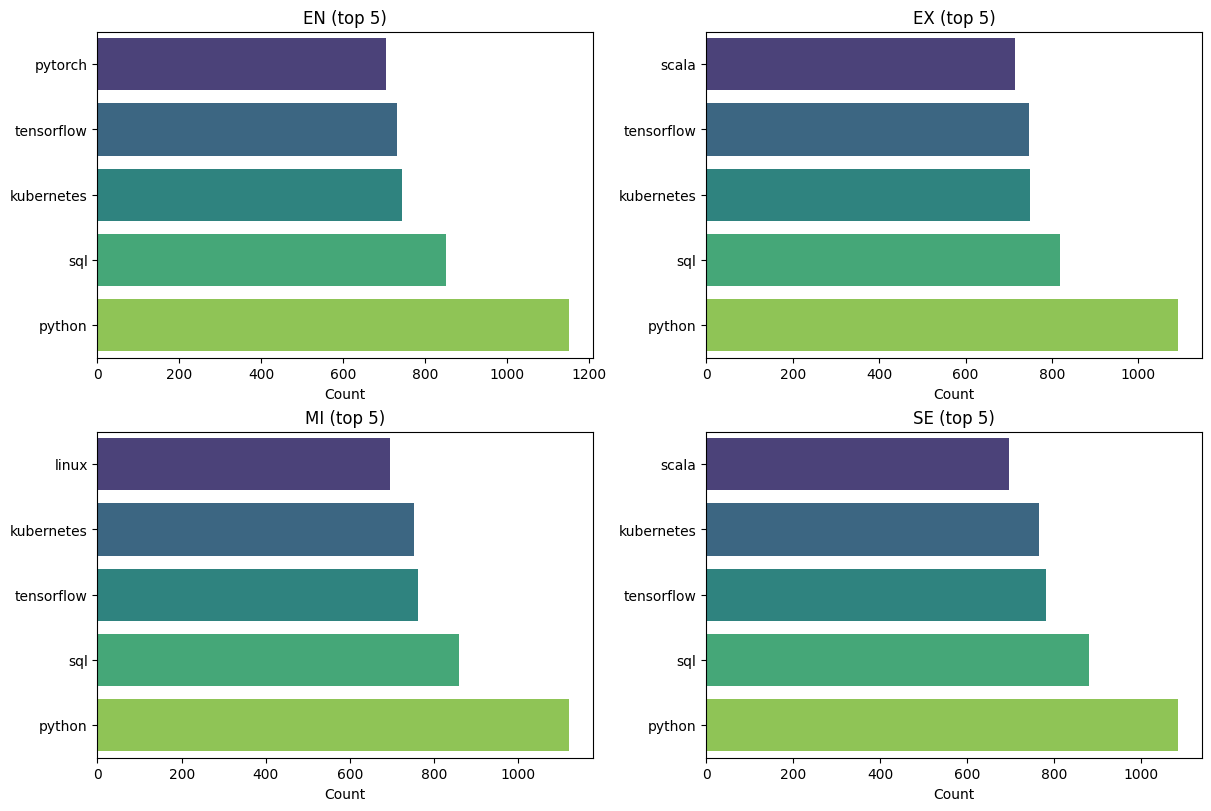

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ensure top_per_level exists (recompute minimally if needed)
if 'top_per_level' not in globals():
    jt = AI_jobs[['experience_level', 'required_skills']].dropna(subset=['experience_level','required_skills']).copy()
    def split_skills(s):
        return [p.strip().lower() for p in re.split(r'[,\n;/\|]+', str(s)) if p.strip()]
    jt['skill_list'] = jt['required_skills'].apply(split_skills)
    exploded = jt.explode('skill_list').rename(columns={'skill_list':'skill'})
    counts = (exploded.groupby(['experience_level','skill']).size().reset_index(name='count'))
    TOP_N = 10
    top_per_level = counts.sort_values(['experience_level','count'], ascending=[True, False]).groupby('experience_level').head(TOP_N).reset_index(drop=True)

# Bar charts: one subplot per experience level
levels = top_per_level['experience_level'].unique()
n = len(levels)
cols = 2
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), constrained_layout=True)
axes = axes.flatten()

for ax, lvl in zip(axes, levels):
    grp = top_per_level[top_per_level['experience_level'] == lvl].sort_values('count')
    sns.barplot(x='count', y='skill', data=grp, ax=ax, palette='viridis')
    ax.set_title(f'{lvl} (top {grp.shape[0]})')
    ax.set_xlabel('Count')
    ax.set_ylabel('')

# hide unused axes
for ax in axes[len(levels):]:
    ax.axis('off')

plt.show()

Generally it seems like the most important skills for any machine learning job include python, sql, kubernetes, tensorflow and pytorch with some other skills potentially required. So regardless of what the job level is these should be the skills that are focused on for most ML engineers.